In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import xgboost as xgb
from xgboost import plot_tree
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [24]:
data = pd.read_csv("sunshinelist.csv")

Let's start off by inspecting the data. Major things to look for: 
1) Are there any categorical variables? 
2) Are there any missing values?
3) Are there any useless columns that can be dropped?

In [25]:
print(data.head())

data = data.drop (columns = ['Last Name', 'First Name'])

print(data.info())

     Sector  Last Name First Name     Salary  Benefits  \
0  Colleges     Abboud      Nadim  116977.21    126.77   
1  Colleges      Agate    Jeffrey  138280.53    392.33   
2  Colleges  Al Dabbah      Rayan  107206.59     21.77   
3  Colleges  Alexander       Doug  115377.97    126.77   
4  Colleges  Alexander      Tamra  116834.24     74.36   

                                           Employer  \
0  Algonquin College Of Applied Arts and Technology   
1  Algonquin College Of Applied Arts and Technology   
2  Algonquin College Of Applied Arts and Technology   
3  Algonquin College Of Applied Arts and Technology   
4  Algonquin College Of Applied Arts and Technology   

                                     Job Title  Year  
0                                    Professor  2021  
1  Associate Director Student Support Services  2021  
2                                    Professor  2021  
3                                    Professor  2021  
4                                    Professo

We can make the following observations:
- There are 244.5K rows, all with complete data (no null values).
- The following columns are categorical: sector, employer, job title.

Now let's learn a little more about the categorical variables.

In [26]:
catvariables = data.select_dtypes(include=['object'])

for col in catvariables.columns:
    print(col +'s', len(data.groupby(col)))

Sectors 17
Employers 2135
Job Titles 38424


                                               Sector  Count
0                                            Colleges   7864
1                                      Crown Agencies   9811
2                   Government of Ontario - Judiciary    630
3   Government of Ontario - Legislative Assembly a...    424
4                  Government of Ontario - Ministries  20312
5                 Hospitals & Boards of Public Health  30580
6                           Municipalities & Services  53834
7                            Ontario Power Generation   8520
8                       Other Public Sector Employers   8796
9                                       School Boards  80447
10                       Seconded (Attorney General)*      2
11                         Seconded (Cabinet Office)*      1
12  Seconded (Children, Community and Social Servi...      6
13                              Seconded (Education)*    100
14                                 Seconded (Health)*      5
15                      

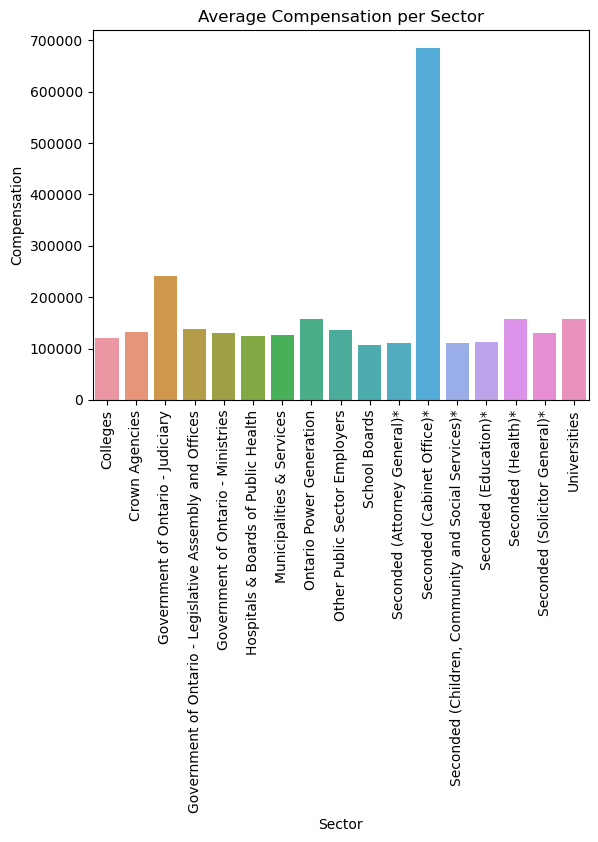

In [27]:
sector_counts = data.groupby('Sector').size().reset_index(name='Count')

print(sector_counts)

data['Compensation'] = data['Salary'] + data['Benefits']

avg_salary = data.groupby('Sector')['Compensation'].mean().reset_index()

sns.barplot(x='Sector', y='Compensation', data=avg_salary)
plt.xticks(rotation = 90)
plt.title('Average Compensation per Sector')
plt.show()

data = data.drop(columns = 'Compensation')

We can see that Seconded (Cabinet Office)* has an abnormally high salary but only 1 user. This is a clear case of an outlier that can be removed from the data. However, let's review any other outliers as well so we can remove all in one go. We can use a boxplot here to visualize any outliers.

<function matplotlib.pyplot.show(close=None, block=None)>

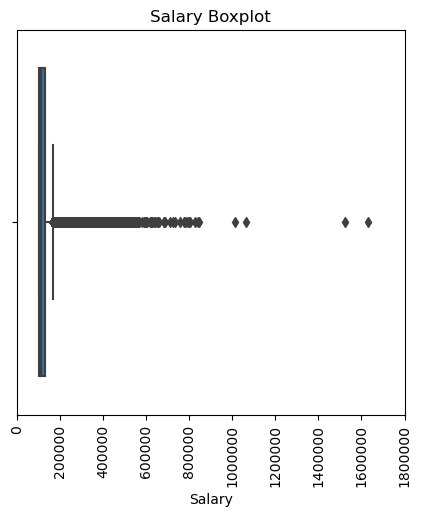

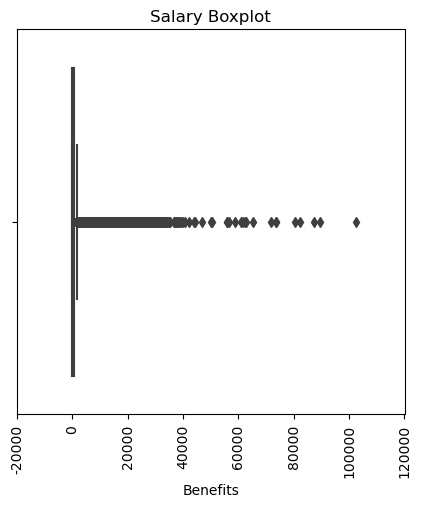

In [28]:
plt.figure(figsize = (5,5))
sns.boxplot(x = 'Salary', data = data)
plt.xticks(rotation=90, ticks=plt.xticks()[0], labels=[f"{int(tick)}" for tick in plt.xticks()[0]])
plt.title('Salary Boxplot')
plt.show

plt.figure(figsize = (5,5))
sns.boxplot(x = 'Benefits', data = data)
plt.xticks(rotation=90, ticks=plt.xticks()[0], labels=[f"{int(tick)}" for tick in plt.xticks()[0]])
plt.title('Salary Boxplot')
plt.show

In [30]:
data = data.query('Salary < 600000')

data = data.query('Benefits < 70000')

data.to_csv('trainingdata.csv', index=False)

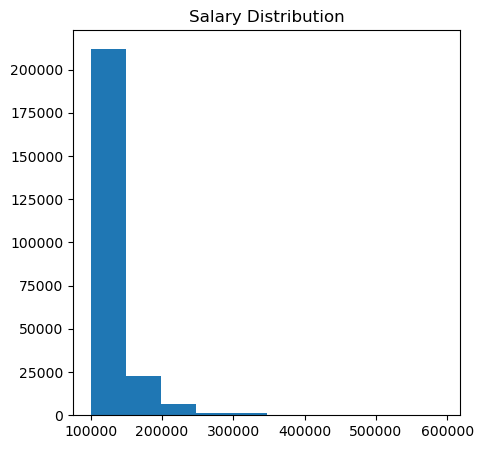

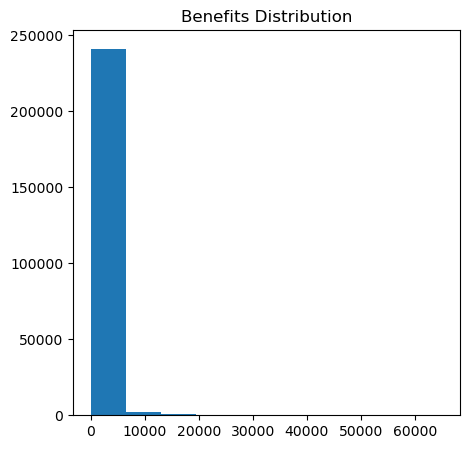

In [23]:
plt.figure(figsize = (5,5))

plt.hist(data['Salary'])
plt.title('Salary Distribution')
plt.show()

plt.figure(figsize = (5,5))

plt.hist(data['Benefits'])
plt.title('Benefits Distribution')
plt.show()

The above distribution makes sense given the dataset is from the sunshine list which only includes salary information for employees earning $100,000 or more. A right skewed distribution is expected in this case. 

Having eliminated outliers, we can now shift our attention to converting the categorical variables into numeric values. We will approach this in 2 ways:
- One-hot encode the 'Sector' variable as it is manageable (17 values).
- Convert Employer and Job Title into numeric values using LabelEncover() as there are too many unique types.

In [9]:
#Creating dummy variables for Sector
dummies = pd.get_dummies(data['Sector'])

data = pd.concat([data, dummies], axis = 1)

data = data.drop(columns = 'Sector', axis = 1)

#Create LabelEncoder objects for categorical variables
employer_le = LabelEncoder()
job_title_le = LabelEncoder()

#Fit LabelEncoder objects to categorical variables
data['Employer_Numeric'] = employer_le.fit_transform(data['Employer'])
data['Job Title_Numeric'] = job_title_le.fit_transform(data['Job Title'])

data = data.drop(columns = ['Employer', 'Job Title'], axis = 1)

Having cleaned the data and converted all variables into numeric values, we can now create a correlation matrix to detect any co-linearity in the data.

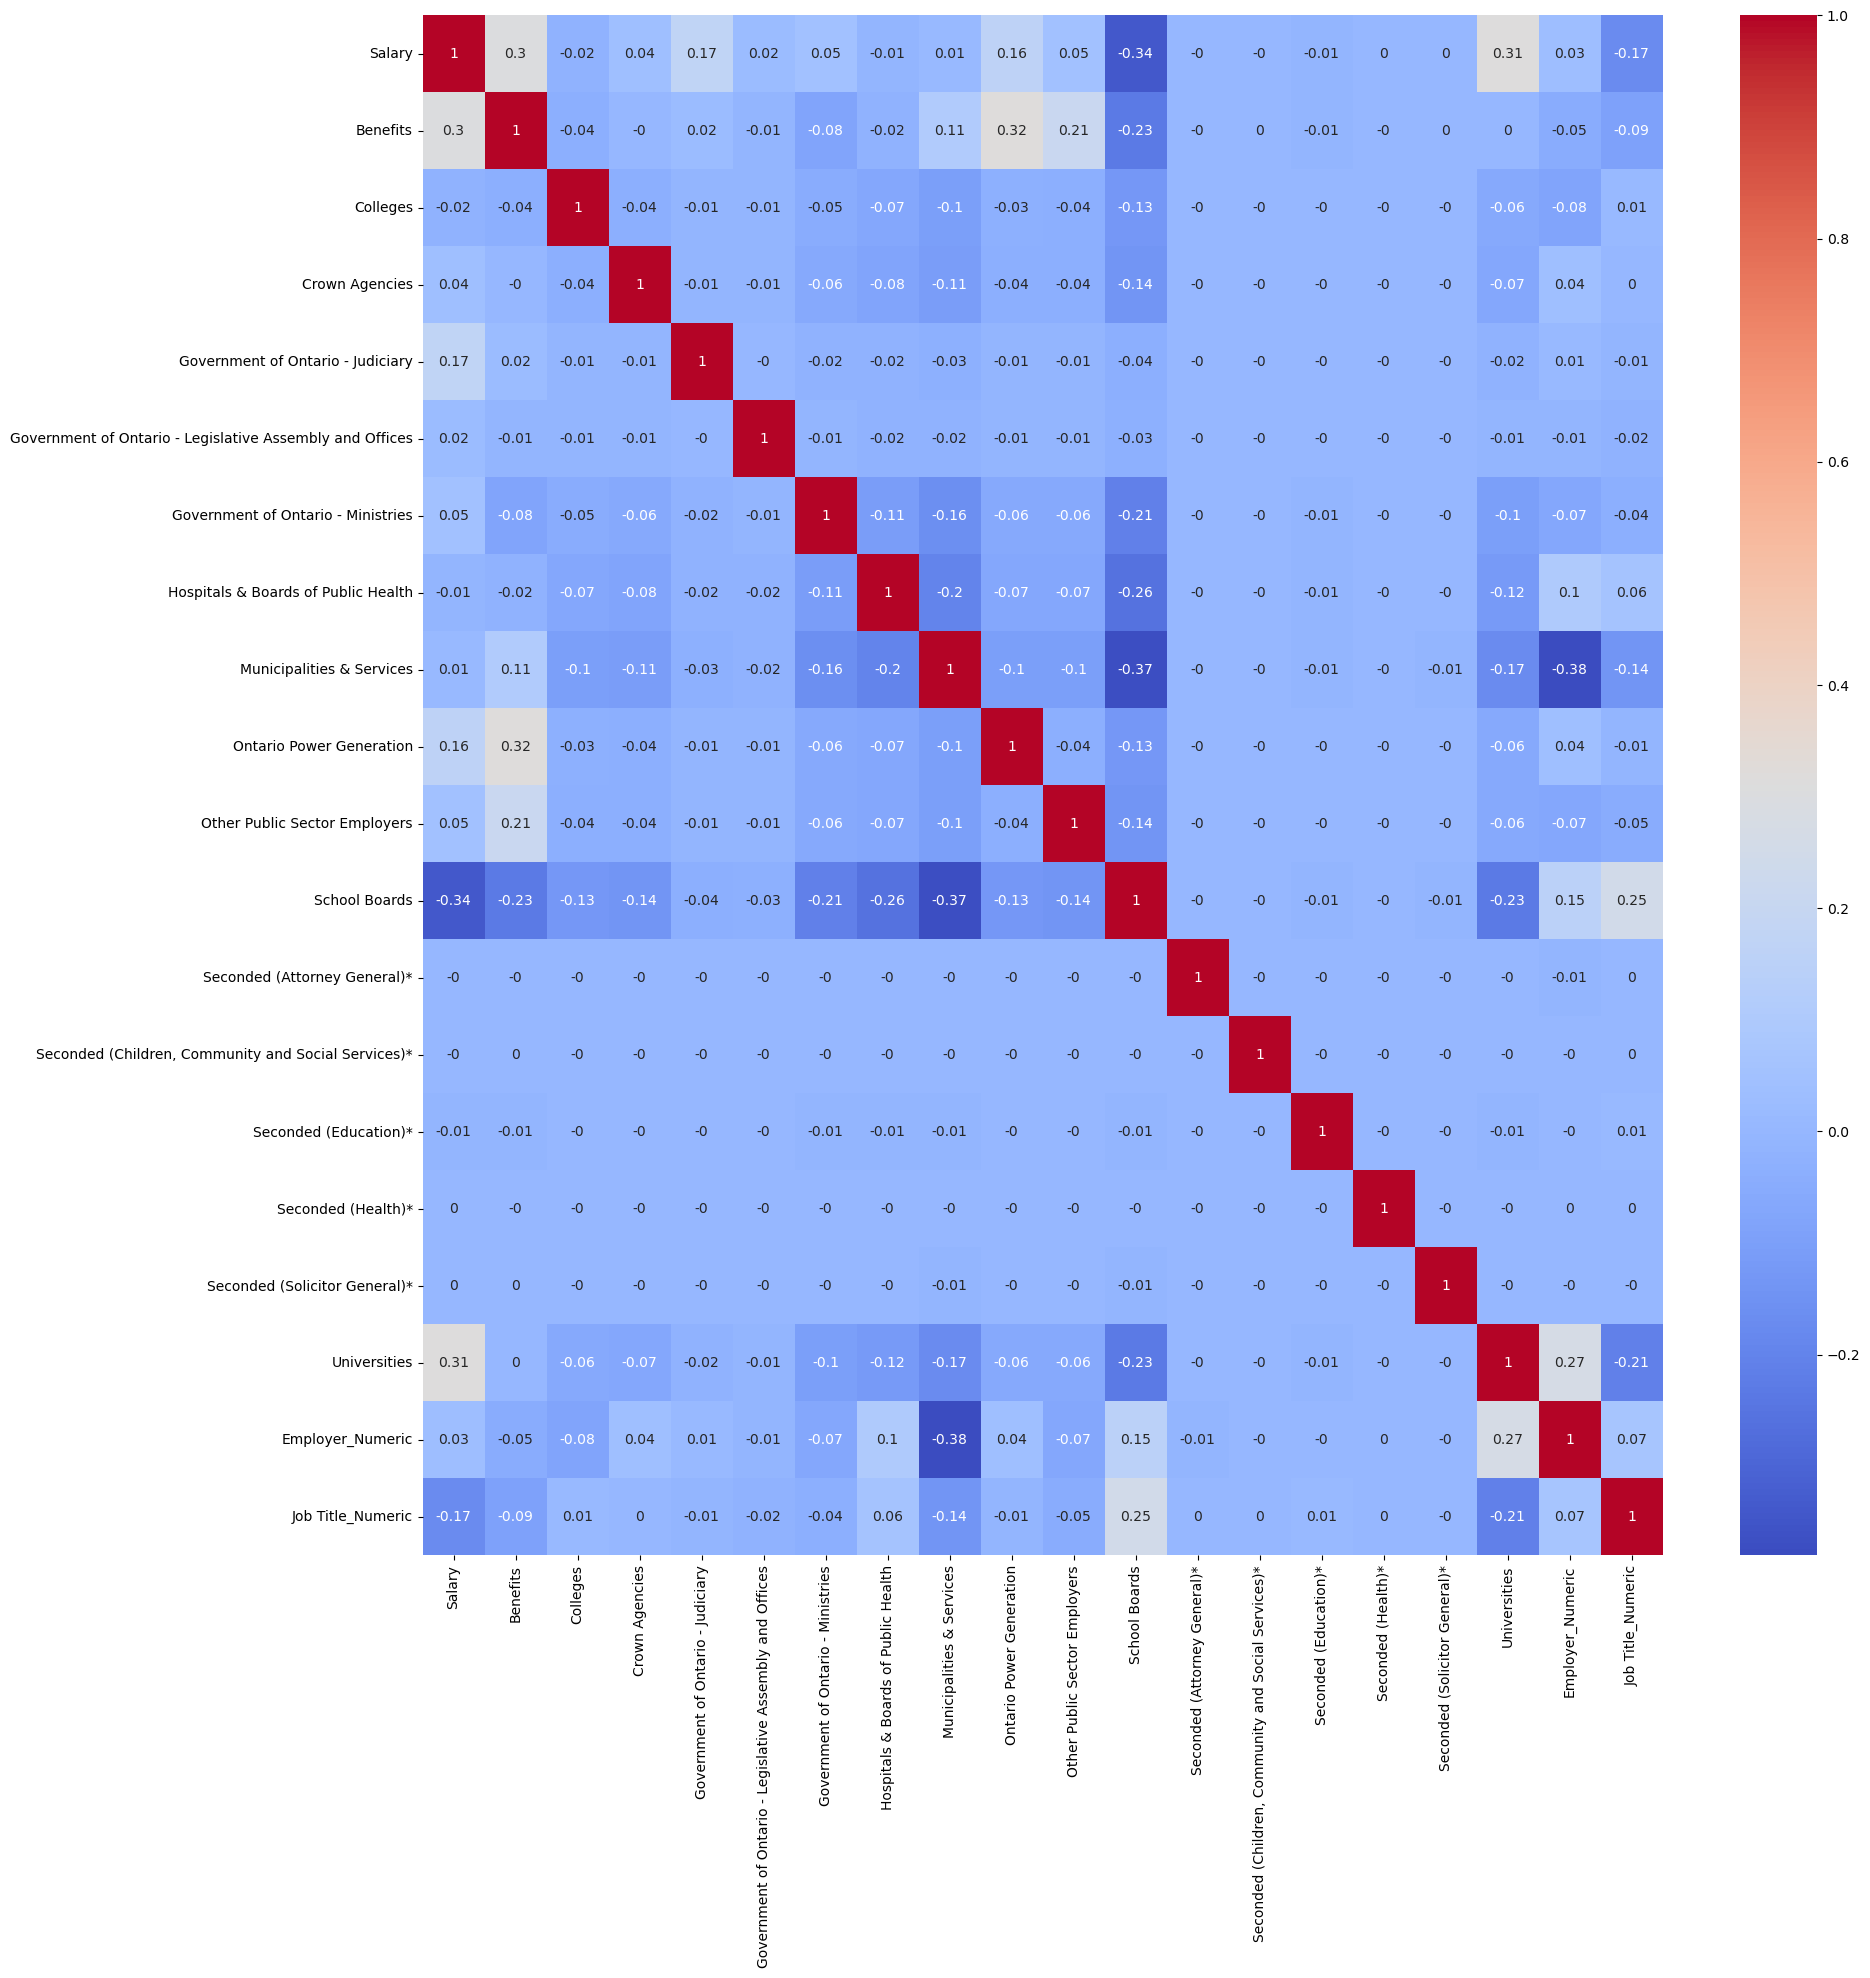

In [10]:
#Calculate the correlation matrix
corr_matrix = round(data.drop(columns = 'Year').corr(), 2)

#Visualize the correlations in a heatmap
plt.figure(figsize = (20,20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

It's great to see there aren't any variables that are highly correlated with each other. We can proceed with creating and training our model now.

In [11]:
#Split the data into training and testing splits
train, test = train_test_split(data, test_size=0.2, random_state=14)

#Identify the targets and features. We will be using Salary and Benefits
#As targets and all remaining columns as features.

####We are targeting salary and benefits in our training subset
targets = (train[['Salary', 'Benefits']])
####Create a list with all other columns as features 
features = list(train.drop(columns=['Salary', 'Benefits']).columns)

#Train an XGBoost Gradient Boosting model on the training data
params = {'objective': 'reg:squarederror'}
model_xgb = xgb.XGBRegressor(**params)
model_xgb.fit(train[features], targets)

#Make predictions on the testing data
predictions = model_xgb.predict(test[features])

Great. Now we can evaluate our model to see how it did.

There are several ways to go about evaluating our model. Some of the popular approaches to evaluating an XGBoost model:
- **Mean Squared Error (MSE)**: commonly used evaluation metric for regression problems. 
- **R-squared (R2)**: statistical measure that represents the proportion of the variance in the target variable that is explained by the model.
- **Root Mean Squared Error (RMSE)**: the square root of the average squared difference between the predicted and actual values.
- **Mean Absolute Error (MAE)**: the average absolute difference between the predicted and actual values, with lower values indicating better performance. 
- **Explained Variance Score (EVS)**: metric that represents the proportion of the variance in the target variable that is explained by the model. This is similar to R-squared but is more robust to outliers and noise in the data. 

In [12]:
#Calculate evaluation metrics
mse = mean_squared_error(test[['Salary', 'Benefits']], predictions)
r2 = r2_score(test[['Salary', 'Benefits']], predictions)
rmse = mean_squared_error(test[['Salary', 'Benefits']], predictions, squared=False)
mae = mean_absolute_error(test[['Salary', 'Benefits']], predictions)
evs = explained_variance_score(test[['Salary', 'Benefits']], predictions)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('Explained Variance Score:', evs)

Mean Squared Error: 214154579.00886965
R2 Score: 0.5623834860255315
Root Mean Squared Error: 10922.548884585267
Mean Absolute Error: 5709.244755930757
Explained Variance Score: 0.5623880057902046


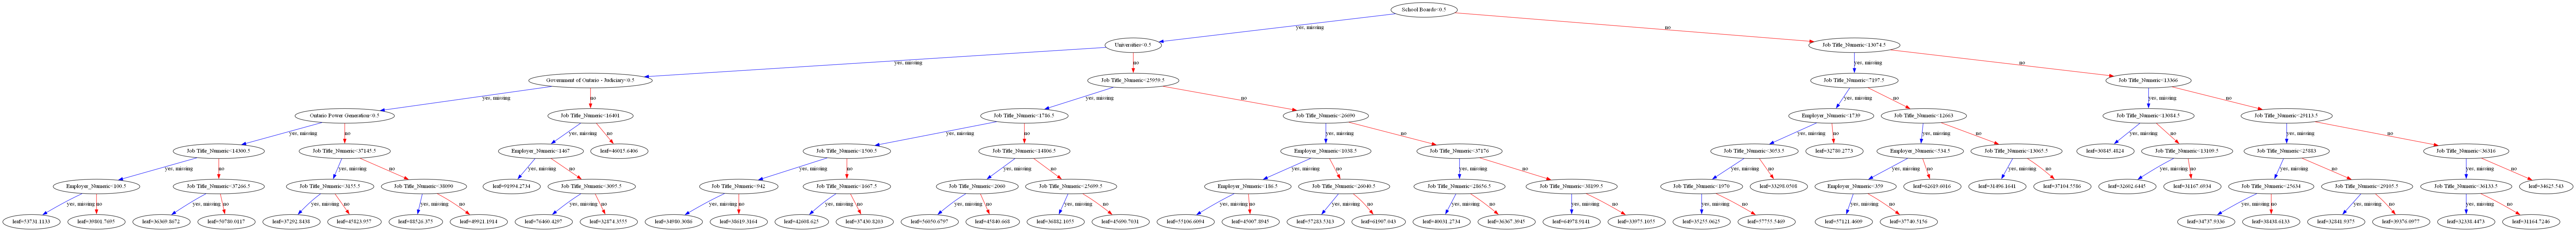

In [13]:
fig, ax = plt.subplots(figsize=(300, 300))
xgb.plot_tree(model_xgb, num_trees=0, ax=ax)
plt.show() 

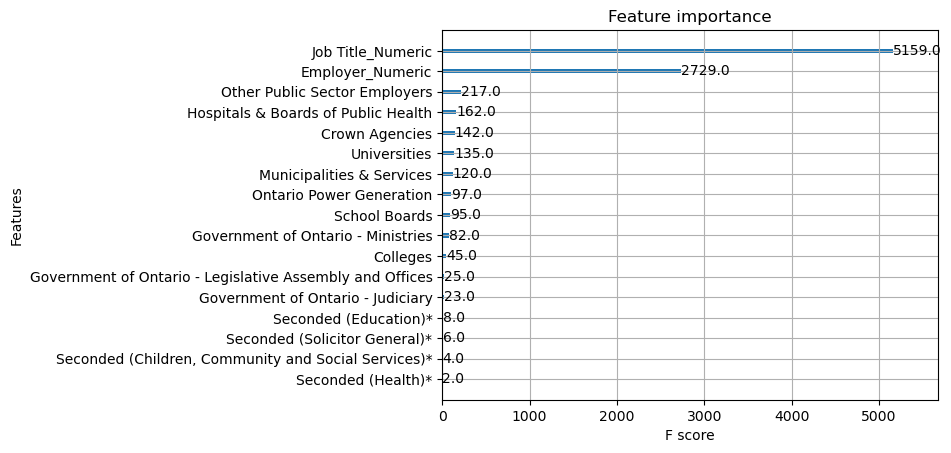

In [14]:
xgb.plot_importance(model_xgb)
plt.show()

### Saving the Model

In [15]:
import pickle

#Save the trained model to a file
with open('model_xgboost.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)
    
# save LabelEncoder objects to disk
with open('employer_le.pkl', 'wb') as f:
    pickle.dump(employer_le, f)
    
with open('job_title_le.pkl', 'wb') as f:
    pickle.dump(job_title_le, f)

In [32]:
features

['Year',
 'Colleges',
 'Crown Agencies',
 'Government of Ontario - Judiciary',
 'Government of Ontario - Legislative Assembly and Offices',
 'Government of Ontario - Ministries',
 'Hospitals & Boards of Public Health',
 'Municipalities & Services',
 'Ontario Power Generation',
 'Other Public Sector Employers',
 'School Boards',
 'Seconded (Attorney General)*',
 'Seconded (Children, Community and Social Services)*',
 'Seconded (Education)*',
 'Seconded (Health)*',
 'Seconded (Solicitor General)*',
 'Universities',
 'Employer_Numeric',
 'Job Title_Numeric']